In [1]:
!pip install supervision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.5/181.5 kB 1.8 MB/s eta 0:00:00


# DATASET ACQUISITION - Download from Kaggle

In [2]:
import matplotlib.pyplot as plt
import supervision as sv
from pathlib import Path
import random

# Update the dataset short name and directory
dataset_shortname = "brackishmot"
data_dir = Path("/mnt/data/tmp/") / dataset_shortname
data_dir.mkdir(exist_ok=True, parents=True)

# Use the Kaggle API to download and unzip the dataset
# (Make sure the Kaggle API is installed and your credentials are configured)
!kaggle datasets download -d maltepedersen/brackishmot -p {data_dir} --unzip


Dataset URL: https://www.kaggle.com/datasets/maltepedersen/brackishmot
License(s): CC-BY-NC-SA-4.0
100% 1.82G/1.83G [00:20<00:00, 25.6MB/s]
100% 1.83G/1.83G [00:20<00:00, 93.7MB/s]


 # DATA CONVERSION - Transform to COCO Format

In [3]:
import os
import json
import pandas as pd
from pathlib import Path
from PIL import Image

# Define paths and parameters
dataset_root = data_dir / "BrackishMOT"
split = "train"
sequences = ['brackishMOT-97','brackishMOT-22','brackishMOT-70',
             'brackishMOT-07','brackishMOT-53','brackishMOT-42']
labels = ['fish', 'crab', 'shrimp', 'starfish', 'small fish', 'jellyfish']

# Initialize COCO dictionary
coco_dict = {"images": [], "annotations": [], "categories": []}

# Create categories (assuming class IDs are 1-indexed)
for i, label in enumerate(labels):
    coco_dict["categories"].append({
        "id": i + 1,
        "name": label,
        "supercategory": "none"
    })

ann_id = 1
image_id = 1

for seq in sequences:
    seq_img_dir = dataset_root / split / seq / "img1"
    seq_gt_path = dataset_root / split / seq / "gt" / "gt.txt"

    # Read the ground truth file
    df = pd.read_csv(seq_gt_path, header=None)
    df.columns = ['frame','id','left','top','width','height','conf','class','visibility']

    # Process each image in the sequence
    for img_file in sorted(os.listdir(seq_img_dir)):
        try:
            frame_number = int(os.path.splitext(img_file)[0])
        except Exception as e:
            print(f"Skipping {img_file}: {e}")
            continue

        # Open image to get width and height
        img_path = seq_img_dir / img_file
        try:
            with Image.open(img_path) as img:
                width, height = img.size
        except Exception as e:
            print(f"Error reading {img_path}: {e}")
            continue

        # Add image entry (store relative path starting from the split folder)
        coco_dict["images"].append({
            "id": image_id,
            "file_name": os.path.join(seq, "img1", img_file),
            "width": width,
            "height": height
        })

        # Filter annotations for the current frame
        df_frame = df[df["frame"] == frame_number]
        for _, row in df_frame.iterrows():
            bbox = [
                int(row['left']),
                int(row['top']),
                int(row['width']),
                int(row['height'])
            ]
            coco_dict["annotations"].append({
                "id": ann_id,
                "image_id": image_id,
                "category_id": int(row['class']),
                "bbox": bbox,
                "area": int(row['width']) * int(row['height']),
                "iscrowd": 0,
            })
            ann_id += 1

        image_id += 1

# Save the converted COCO JSON
annotations_path = data_dir / "brackishmot_coco.json"
with open(annotations_path, "w") as f:
    json.dump(coco_dict, f)

print(f"COCO annotations saved to: {annotations_path}")


COCO annotations saved to: /mnt/data/tmp/brackishmot/brackishmot_coco.json


# DATASET VISUALIZATION - Load and display samples

Loaded dataset with 924 images.
Dataset classes: ['fish', 'crab', 'shrimp', 'starfish', 'small fish', 'jellyfish']


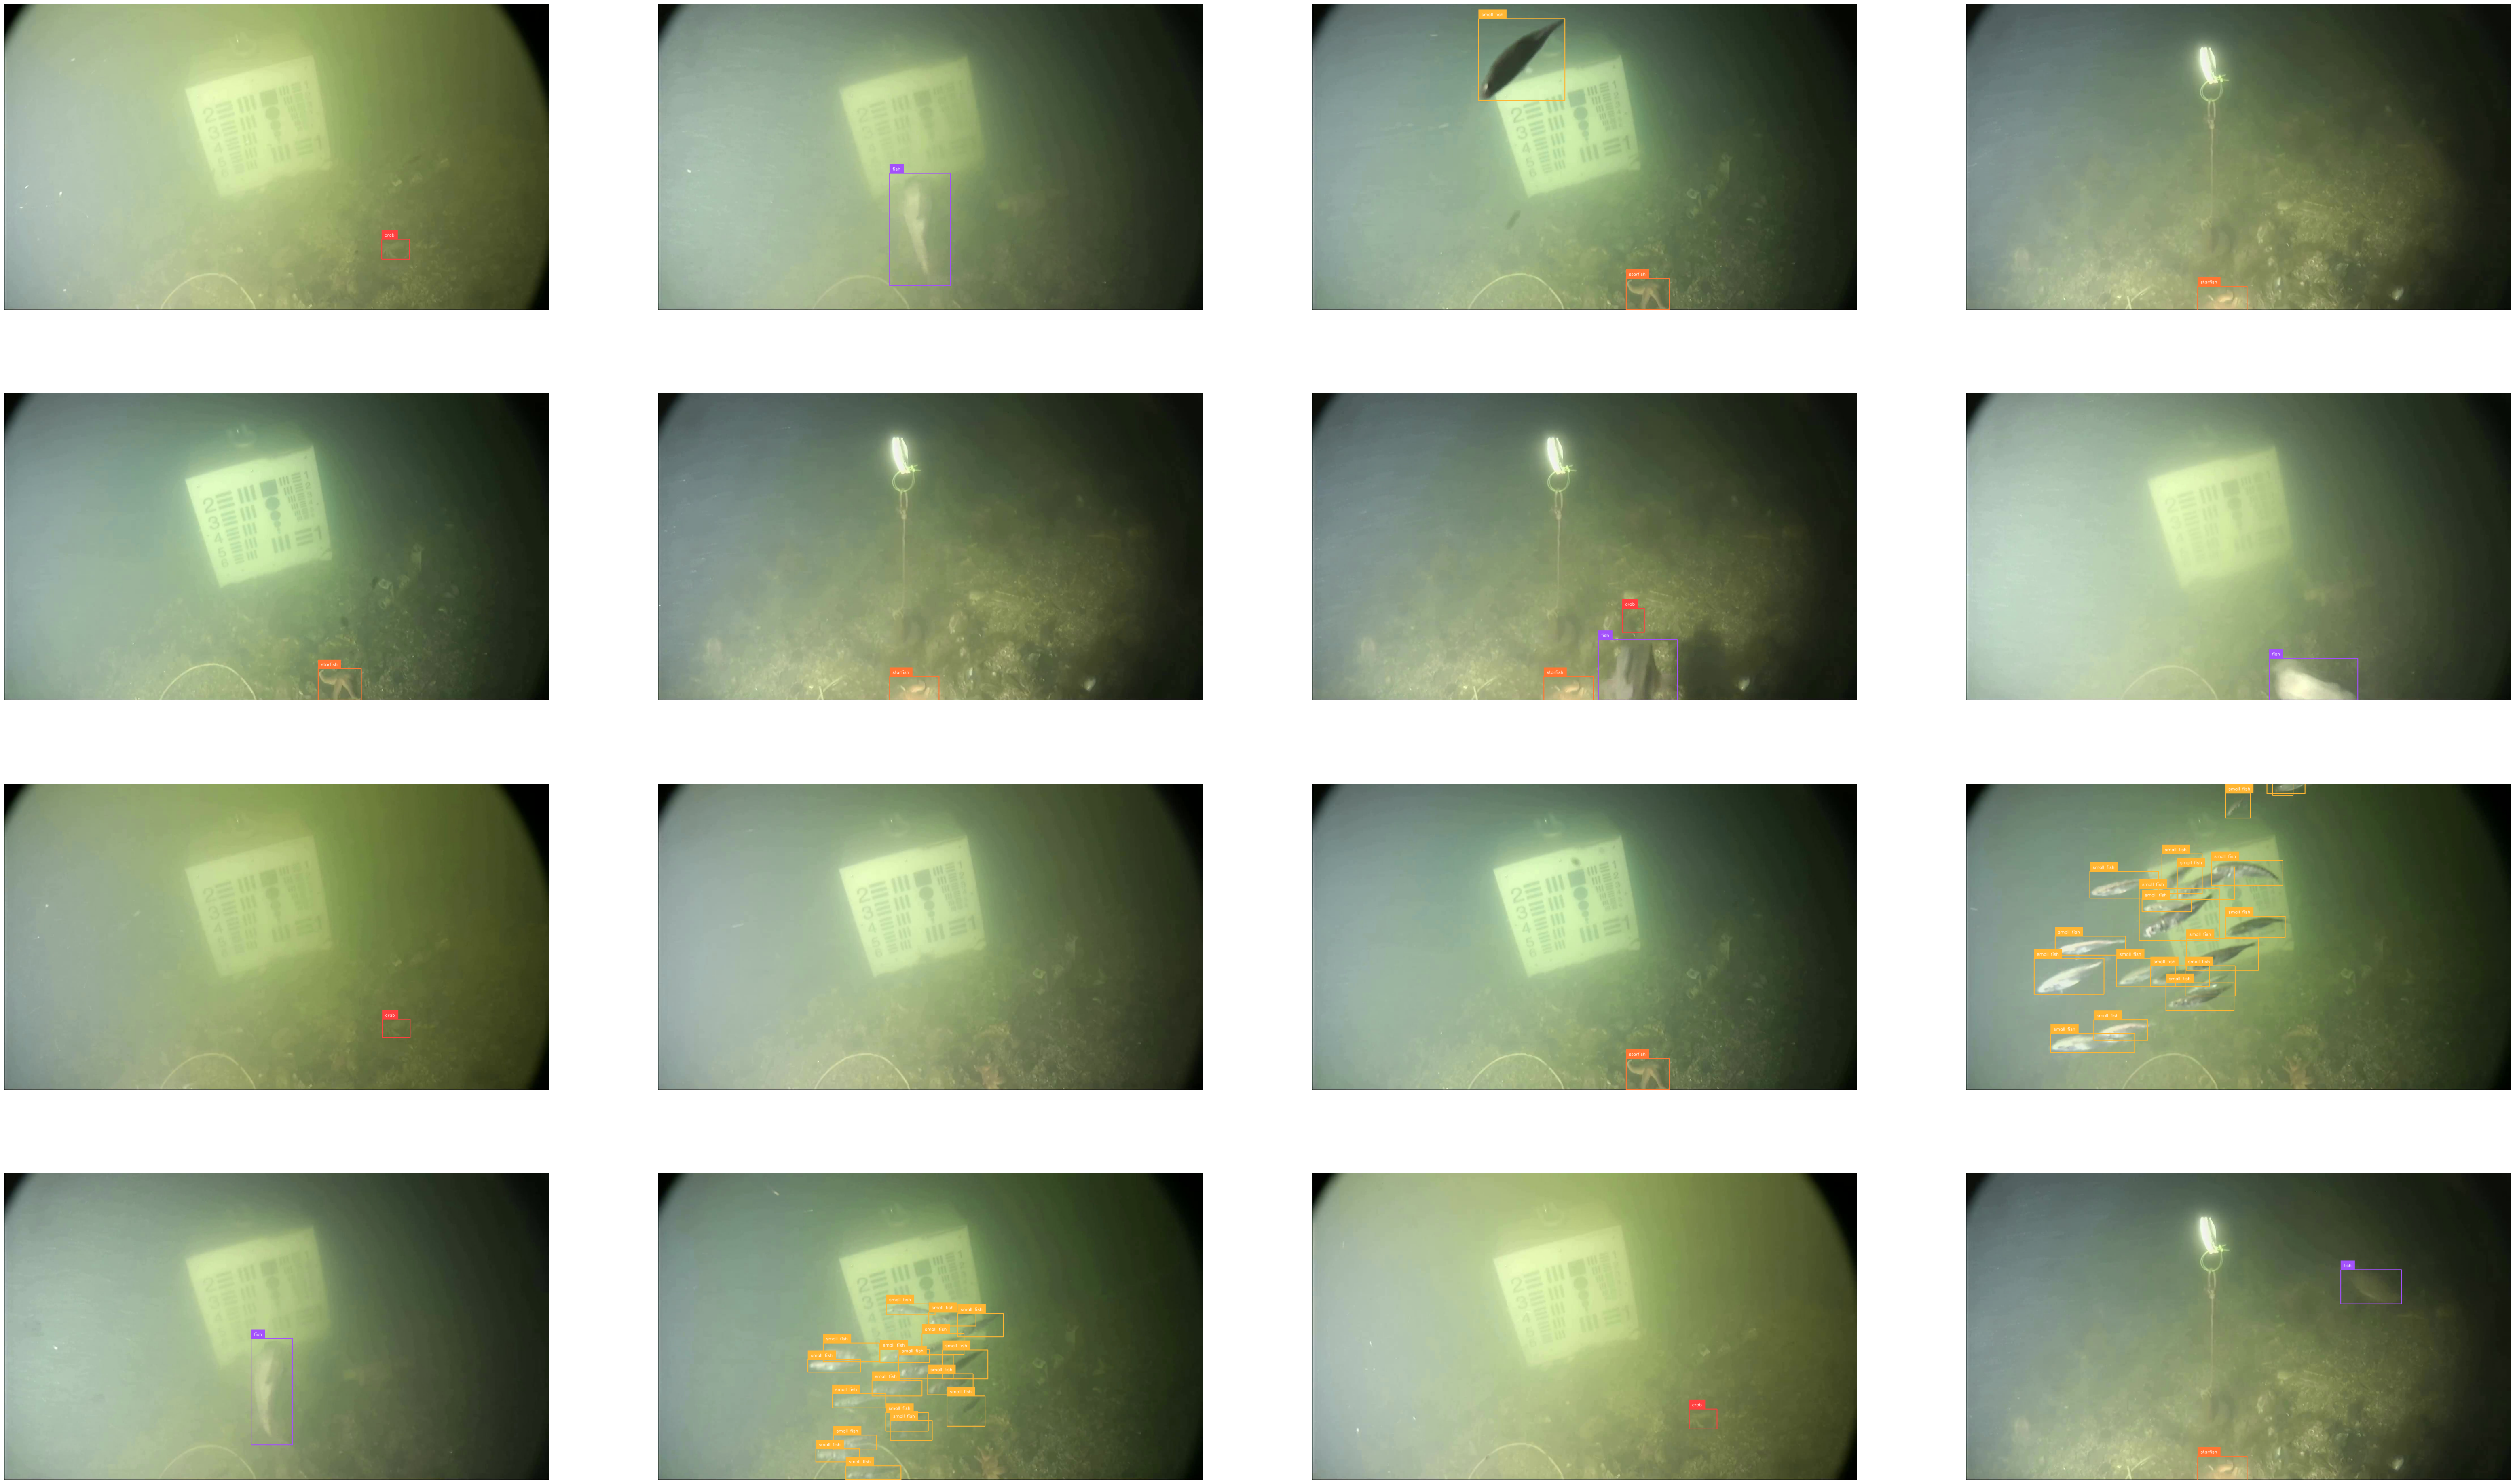

Visualization complete!


In [4]:
import supervision as sv
from pathlib import Path
import random
import matplotlib.pyplot as plt

# Define the images directory (adjust this if your structure is different)
# Assuming dataset_root is already defined as: data_dir / "BrackishMOT"
images_directory_path = dataset_root / "train"  # This should contain your sequence folders (e.g., brackishMOT-97, etc.)

# Load the dataset using the COCO annotations we just created
dataset = sv.DetectionDataset.from_coco(
    images_directory_path=str(images_directory_path),
    annotations_path=str(annotations_path),
)

print(f"Loaded dataset with {len(dataset)} images.")
print(f"Dataset classes: {dataset.classes}")

# Initialize annotators for visualization
box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator()

# Visualize a grid of random samples from the dataset
annotated_images = []
image_example = None

for _ in range(16):
    idx = random.randint(0, len(dataset) - 1)
    _, image, annotations = dataset[idx]

    # Map class IDs to their label names
    ann_labels = [dataset.classes[class_id] for class_id in annotations.class_id]

    annotated_image = image.copy()
    annotated_image = box_annotator.annotate(annotated_image, annotations)
    annotated_image = label_annotator.annotate(annotated_image, annotations, ann_labels)
    annotated_images.append(annotated_image)

    if len(annotations) > 0:
        image_example = annotated_image

# Plot the grid of annotated images
sv.plot_images_grid(
    annotated_images,
    grid_size=(4, 4),
    titles=None,
    size=(80, 48),
    cmap="gray"
)

# Optionally, save one preview image
output_preview_dir = Path("data_preview")
output_preview_dir.mkdir(exist_ok=True, parents=True)
plt.imsave(output_preview_dir / "brackishmot_sample_image.png", image_example)

print("Visualization complete!")


In [5]:
print(f"Dataset classes: {dataset.classes}")

Dataset classes: ['fish', 'crab', 'shrimp', 'starfish', 'small fish', 'jellyfish']
